### Import

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import skimage
from tqdm import tqdm

### Dataloader

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root):
        self.images_path = os.path.join(root, "images")
        self.masks_path = os.path.join(root, "masks")
        self.filenames = os.listdir(self.images_path)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = skimage.io.imread(os.path.join(self.images_path, filename))
        mask = skimage.io.imread(os.path.join(self.masks_path, filename))
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

### U NET model

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((1, 3, 520, 696))
    model = UNET(in_channels=3, out_channels=3)
    preds = model(x)
    assert preds.shape == x.shape
    print(preds.shape)
if __name__ == "__main__":
    test()

c:\Users\chedl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 520, 696])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training

In [36]:
from torch.cuda.amp import autocast, GradScaler


scaler = GradScaler()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set paths for train dataset
train_data_path = "data/splits/train"

# Load and preprocess the train dataset
train_dataset = CustomDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create an instance of the U-Net model
in_channels = 3  # Number of input channels (e.g., RGB image)
out_channels = 3  # Number of output channels (e.g., binary mask)
model = UNET(in_channels, out_channels).to(device)

#Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        #print(images.shape, masks.shape)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), "model/unet_model.pth")


Epoch [1/5], Loss: 0.42447105050086975
Epoch [2/5], Loss: 0.4180053472518921
Epoch [3/5], Loss: 0.4779498279094696
Epoch [4/5], Loss: 0.4839245080947876
Epoch [5/5], Loss: 0.5216981172561646


### Validation

In [10]:
# Set paths for validation dataset
val_data_path = "data/splits/validation"

# Load the trained model
model = UNET(in_channels=3, out_channels=3).to(device)
model.load_state_dict(torch.load("model/unet_model.pth"))
model.eval()
model.to(device)

# Create the validation dataset
val_dataset = CustomDataset(val_data_path)

# Create the validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

criterion = nn.BCEWithLogitsLoss() 

total_loss = 0
num_samples = 0

with torch.no_grad():
    for images, masks in val_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        total_loss += loss.item()
        num_samples += images.size(0)

average_loss = total_loss / num_samples
print(f"Average loss on validation set: {average_loss}")

Average loss on validation set: 0.25948230385780335


### Predicted Images

torch.Size([1, 3, 520, 696])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 520, 696])


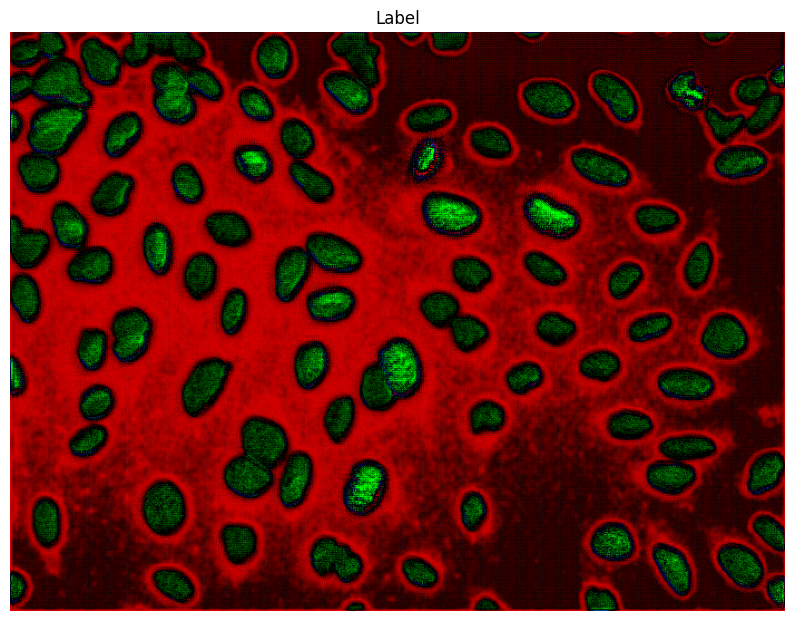

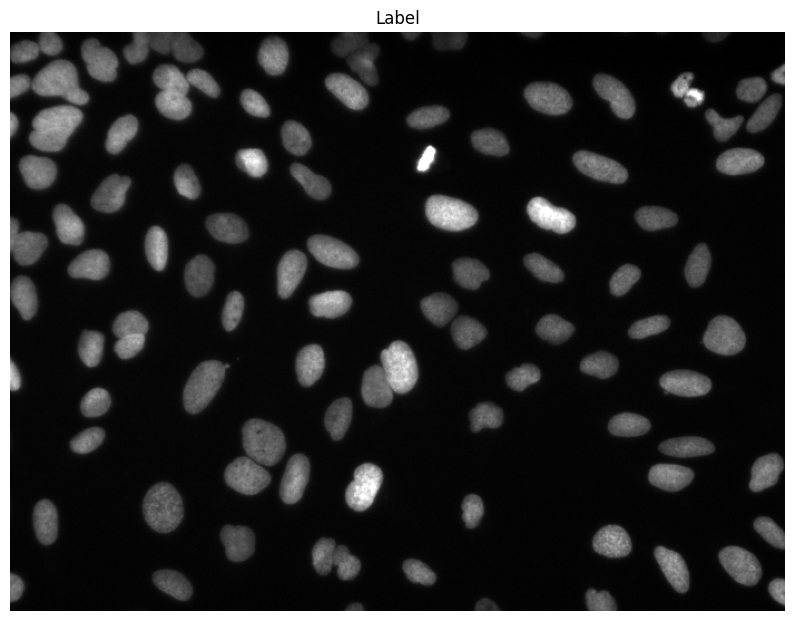

In [12]:
val_data_path = "data/splits/validation"

# Load the trained model
model = UNET(in_channels=3, out_channels=3)
model.load_state_dict(torch.load("model/unet_model.pth"))
model.eval()
val_dataset = CustomDataset(val_data_path)

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
model.to('cpu')
img , _ = next(iter(val_dataloader))

print(img.shape)
pred = model(img)
print(pred.shape)
pred = pred[0]

import matplotlib.pylab as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(pred.detach().numpy().transpose(1, 2, 0))
plt.title('Label')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(img[0].detach().numpy().transpose(1, 2, 0))
plt.title('Label')
plt.axis('off')
plt.show()